In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from sklearn.linear_model import LinearRegression
# import utils as ut

In [2]:
def get_D_alpha(traj, min_length=10, numPoints=5):
    if traj.shape[0]<min_length:
        return np.nan, np.nan, np.nan, np.nan,np.nan
    model = LinearRegression()
    x = np.log10(traj.loc[traj.correction=="corrected","lags(s)"])
    y = np.log10(traj.loc[traj.correction=="corrected","MSD(µm^2)"])
    sampleWeight = traj.loc[traj.correction=="corrected","weight"]
    #print(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints], sampleWeight.to_numpy()[:numPoints])
    model.fit(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints])#, sample_weight = sampleWeight.to_numpy()[:numPoints])
    y_pred = model.predict(x.to_numpy().reshape(-1,1))
    return model.intercept_, model.coef_[0],traj.iloc[0].treatment,traj.iloc[0].file,traj.iloc[0].channel#10**y_pred,10**x

# Open all the data

In [3]:
list_files_cor = glob.glob('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/*/msd_corrected__*')
list_files_uncor = glob.glob('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/*/msd_uncorrected__*')

In [4]:
list_files = list_files_cor + list_files_uncor

In [5]:
for i in list_files:
    if 'uncorrected' in i:
        print(i)

/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20220907_Rad21-Halo_SPT_2D5_Sororin_noaux_40mW_2/msd_uncorrected__20220907_Rad21-Halo_SPT_2D5_Sororin_noaux_40mW_2.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230605_Rad21-Halo_G6_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/msd_uncorrected__20230605_Rad21-Halo_G6_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/msd_uncorrected__20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230529_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/msd_uncorrected__20230529_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv
/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWith

In [6]:
df_list = []
for file in list_files:
    df = pd.read_csv(file)
    df.tamsd = df.tamsd*(0.16**2) # from pixel to µm
    df.lags = df.lags*10 # from frame to seconds
    df.tamsd = df.tamsd - (2*(0.035**2)) # subtract the localization error
    df.rename(columns={'tamsd':'MSD(µm^2)','lags':'lags(s)'}, inplace=True)

    if 'NIPBL' in file:
        df['cell_type'] = ['NIPBL']*len(df)
    if 'sororin' in file or 'Sororin' in file:
        df['cell_type'] = ['sororin']*len(df)
    if 'G6' in file:
        df['cell_type'] = ['WT']*len(df)
        df['treatment'] = ['untreated']*len(df)
    
    if '6h' in file or '3h' in file:
        df['treatment'] = ['treated']*len(df)
    if '0h' in file:
        df['treatment'] = ['untreated']*len(df)
    if '40mW' in file:
        df['treatment'] = ['untreated']*len(df)
    
    if 'corrected' in file:
        df['correction'] = ['corrected']*len(df)
    if 'uncorrected' in file:
        df['correction'] = ['uncorrected']*len(df)


    df['file'] = [file.split('/')[7]]*len(df)
    df.replace('w1','cohesin', inplace=True)
    df.replace('w2','DNA', inplace=True)
    df_list.append(df)

df_combined = pd.concat(df_list)


In [30]:
df_NIPBL_treated = df_combined[(df_combined['cell_type']=='NIPBL') & (df_combined['treatment']=='treated')].copy(deep=True)
df_NIPBL_untreated = df_combined[(df_combined['cell_type']=='NIPBL') & (df_combined['treatment']=='untreated')].copy(deep=True)
df_sororin_treated = df_combined[(df_combined['cell_type']=='sororin') & (df_combined['treatment']=='treated')].copy(deep=True)
df_sororin_untreated = df_combined[(df_combined['cell_type']=='sororin') & (df_combined['treatment']=='untreated')].copy(deep=True)
df_wt = df_combined[(df_combined['cell_type']=='WT') & (df_combined['treatment']=='untreated')].copy(deep=True)

In [31]:
df_NIPBL = pd.concat([df_NIPBL_treated,df_NIPBL_untreated])
df_NIPBL = df_NIPBL[df_NIPBL.correction == 'corrected']

df_sororin = pd.concat([df_sororin_treated,df_sororin_untreated])
df_sororin = df_sororin[df_sororin.correction == 'corrected']

df_treated = pd.concat([df_NIPBL_treated,df_sororin_treated])
df_treated = df_treated[df_treated.correction == 'corrected']

df_untreated = pd.concat([df_NIPBL_untreated,df_sororin_untreated])
df_untreated = df_untreated[df_untreated.correction == 'corrected']

In [106]:
df_untreated.to_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/df_untreated.csv')

## NIPBL untreated

(7.763671403696786, 2035.1196203997763)

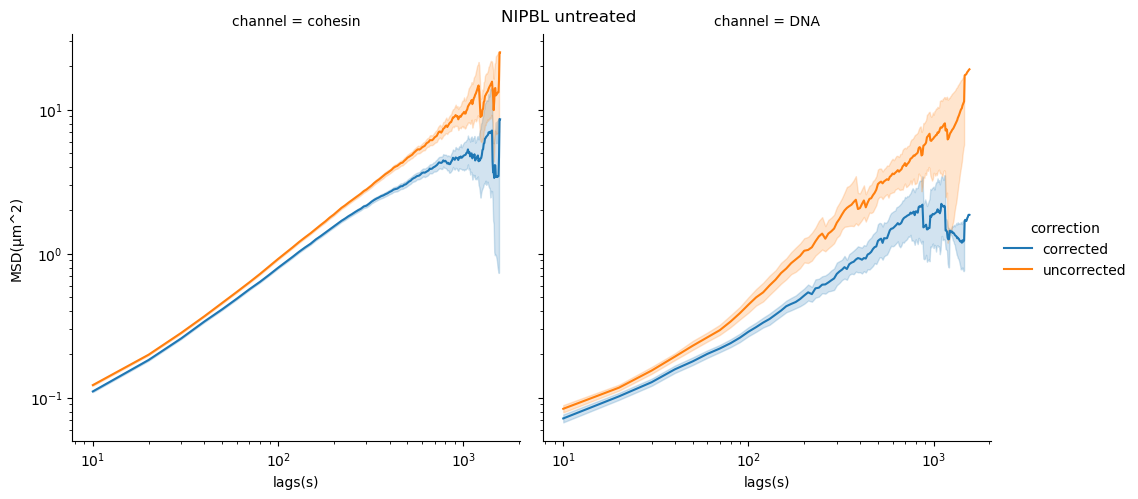

In [42]:
a = sns.relplot(data=df_NIPBL_untreated, x='lags(s)', y='MSD(µm^2)', hue='correction', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
a.fig.suptitle('NIPBL untreated')
plt.ylim(0.05003019815098578, 33.5852003096169)
plt.xlim(7.763671403696786, 2035.1196203997763)

In [41]:
a.axes[0,0].get_xlim()

(7.763671403696786, 2035.1196203997763)

### check correction

In [5]:
path_tracks_unc = ['/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230529_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230529_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
'/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230529_Rad21-Halo_NIPBL_1C5_6h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230529_Rad21-Halo_NIPBL_1C5_6h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
'/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230531_Rad21-Halo_NIPBL_1C5_6h_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230531_Rad21-Halo_NIPBL_1C5_6h_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv']

df_list = []

for path in path_tracks_unc:
    df = pd.read_csv(path)
    df['file'] = [path.split('/')[7]] * len(df)
    df_list.append(df)

df_tracks_unc = pd.concat(df_list)
df_tracks_unc = df_tracks_unc[df_tracks_unc.channel == 'w2']

In [6]:
df_tracks_unc = ut.filter_tracks(df_tracks_unc)

In [7]:
df_unc_w2_msd_rad = ut.calculate_all_pairwise_tamsd(df_tracks_unc,radial=True)

3335544431.py (1): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
3335544431.py (1): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
3335544431.py (2): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
3335544431.py (2): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
3335544431.py (3): The default value

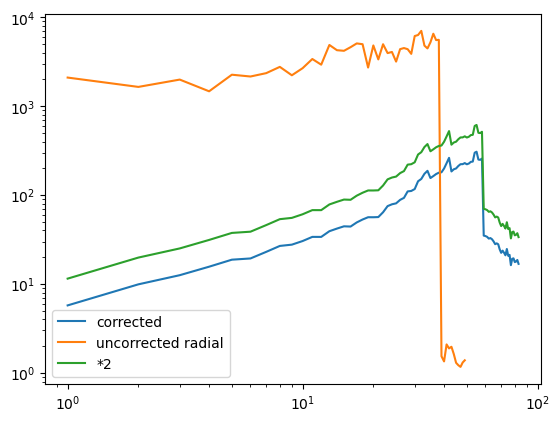

In [20]:
plt.plot(df_treated[(df_treated.correction == 'corrected') & (df_treated.channel == 'w2')].groupby('lags').mean().index,df_treated[(df_treated.correction == 'corrected') & (df_treated.channel == 'w2')].groupby('lags').mean().tamsd,label= 'corrected')
plt.plot(df_unc_w2_msd_rad.groupby('lags').mean().index,df_unc_w2_msd_rad.groupby('lags').mean().tamsd,label= 'uncorrected radial')
plt.plot(df_treated[(df_treated.correction == 'corrected') & (df_treated.channel == 'w2')].groupby('lags').mean().index,df_treated[(df_treated.correction == 'corrected') & (df_treated.channel == 'w2')].groupby('lags').mean().tamsd*2,label= '*2')
plt.xscale('log')
plt.yscale('log')
plt.legend()

### fit

In [13]:
df_NIPBL_cor = df_NIPBL[df_NIPBL.correction == 'corrected'].copy(deep=True)

In [55]:
intercept_w1,slope_w1,y_w1,x_w1 = get_D_alpha(df_NIPBL_cor[df_NIPBL_cor.channel == 'cohesin'],numPoints=5)
intercept_w2,slope_w2,y_w2,x_w2 = get_D_alpha(df_NIPBL_cor[df_NIPBL_cor.channel == 'DNA'],numPoints=2)

In [56]:
slope_w2

0.5994582265487627

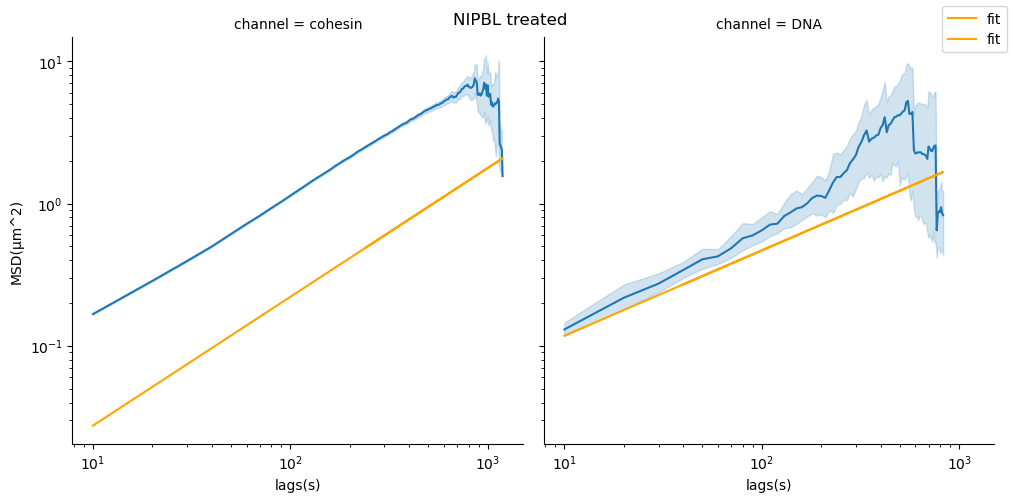

In [57]:
rel = sns.relplot(data=df_NIPBL_cor, x='lags(s)', y='MSD(µm^2)', col='channel', kind='line')
plt.xscale('log')
plt.yscale('log')
rel.fig.suptitle('NIPBL treated')

a = rel.axes.flatten()

for y,x,ax in zip([y_w1,y_w2],[x_w1,x_w2],a):
    ax.plot(x,y,label='fit',c='orange')
    ax.set_xscale('log')
    ax.set_yscale('log')

rel.fig.legend()

In [119]:
df_NIPBL_cor.uniqueid.unique()

array(['753a990a4a7f42c4', '46cb810d7403dee5', 'fe92426a25db9777', ...,
       '99744d8d8824c184', 'd79845a283ead50e', '9e2602614af341fc'],
      dtype=object)

In [121]:
def get_D_alpha(traj, min_length=10, numPoints=5):
    if traj.shape[0]<min_length:
        return np.nan, np.nan, np.nan, np.nan,np.nan,np.nan
    model = LinearRegression()
    x = np.log10(traj.loc[traj.correction=="corrected","lags(s)"])
    y = np.log10(traj.loc[traj.correction=="corrected","MSD(µm^2)"])
    sampleWeight = traj.loc[traj.correction=="corrected","weight"]
    #print(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints], sampleWeight.to_numpy()[:numPoints])
    model.fit(x.to_numpy().reshape(-1,1)[:numPoints], y.to_numpy()[:numPoints])#, sample_weight = sampleWeight.to_numpy()[:numPoints])
    y_pred = model.predict(x.to_numpy().reshape(-1,1))
    return model.intercept_, model.coef_[0],10**y_pred,10**x

In [122]:
intercept_w1,slope_w1,y_w1,x_w1 = get_D_alpha(df_NIPBL_cor[(df_NIPBL_cor.channel == 'cohesin')&(df_NIPBL_cor.uniqueid == '753a990a4a7f42c4')],numPoints=5)
intercept_w2,slope_w2,y_w2,x_w2 = get_D_alpha(df_NIPBL_cor[(df_NIPBL_cor.channel == 'DNA')&(df_NIPBL_cor.uniqueid == '753a990a4a7f42c4')],numPoints=2)

ValueError: too many values to unpack (expected 4)

In [10]:
df_sororin_cor = df_sororin[df_sororin.correction == 'corrected'].copy(deep=True)

In [11]:
coefficients_sor = df_sororin_cor.groupby(by="uniqueid").apply(get_D_alpha, min_length=10, numPoints=5).to_frame()
coefficients_sor.head()

,0
uniqueid,
0004f54fcc4e5df0,"(-2.08840469063344, 1.0826470475122651, untrea..."
0006f766fe1e8656,"(-1.0881967822622474, 0.5726482875415383, trea..."
0007ba8b9676cbdf,"(-1.4590060572163068, 0.5341027998612454, trea..."
000972634428bfc9,"(-2.234984069904269, 1.3213617378759568, untre..."
000a4bef5d03ca80,"(-1.8456770336962278, 1.0233006243328888, untr..."


In [14]:
coefficients_nip = df_NIPBL_cor.groupby(by="uniqueid").apply(get_D_alpha, min_length=10, numPoints=5).to_frame()
coefficients_nip.head() 

,0
uniqueid,
0003e1a30bd30b76,"(-1.437238968425865, 0.8679430493892928, treat..."
0008680c0f633773,"(-1.8121242032597578, 1.0572448579533023, untr..."
00106df50c009731,"(-1.4373877819411995, 0.7337300800948846, trea..."
00145a133dcbdd71,"(-1.1262734582790164, 0.6077886404429695, trea..."
0015e15f2fc28fe0,"(-1.94095824266378, 0.9654413626022686, untrea..."


In [15]:
for coefficients in [coefficients_nip,coefficients_sor]:
    coefficients['D'], coefficients['alpha'], coefficients['treatment'], coefficients['file'],coefficients['channel'] = zip(*coefficients.iloc[:,0])
    coefficients['D'] = 10**coefficients['D']
    coefficients.drop(columns=[0],inplace=True)
    
# coefficients['D'], coefficients['alpha'],coefficients['treatment'],coefficients['file'],coefficients['channel'],coefficients['treatment']= zip(*coefficients.iloc[:,0])
# coefficients.D = 10**coefficients.D

In [16]:
coefficients_sor['cell_type'] = ['sororin']*len(coefficients_sor)
coefficients_nip['cell_type'] = ['NIPBL']*len(coefficients_nip)

In [17]:
coefficients = pd.concat([coefficients_sor,coefficients_nip])

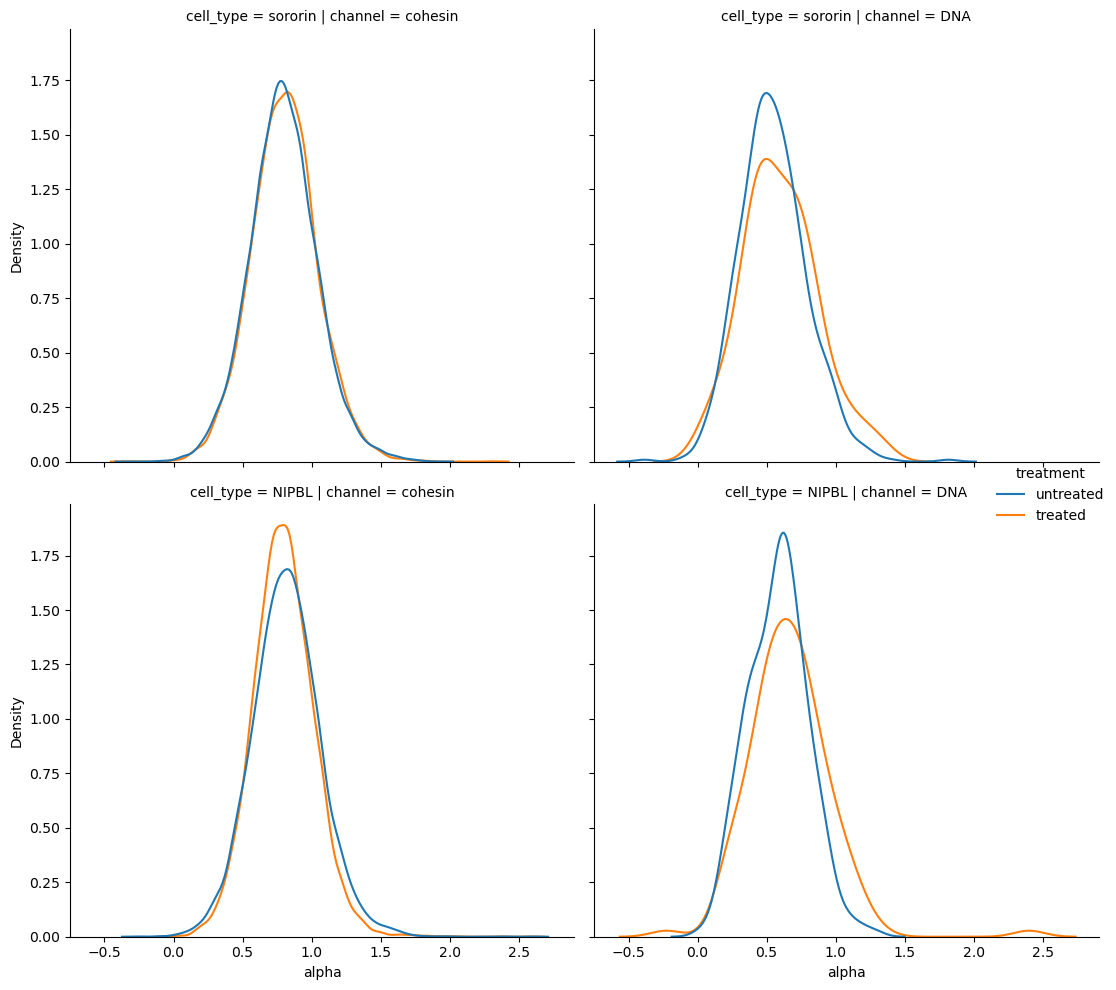

In [18]:
a = sns.displot(data=coefficients, x="alpha", kind="kde", hue="treatment",common_norm=False,col='channel',row='cell_type')
# a.fig.suptitle('NIPBL')
plt.tight_layout()
plt.savefig('NIPBL_sororin_alpha.png',dpi=300)

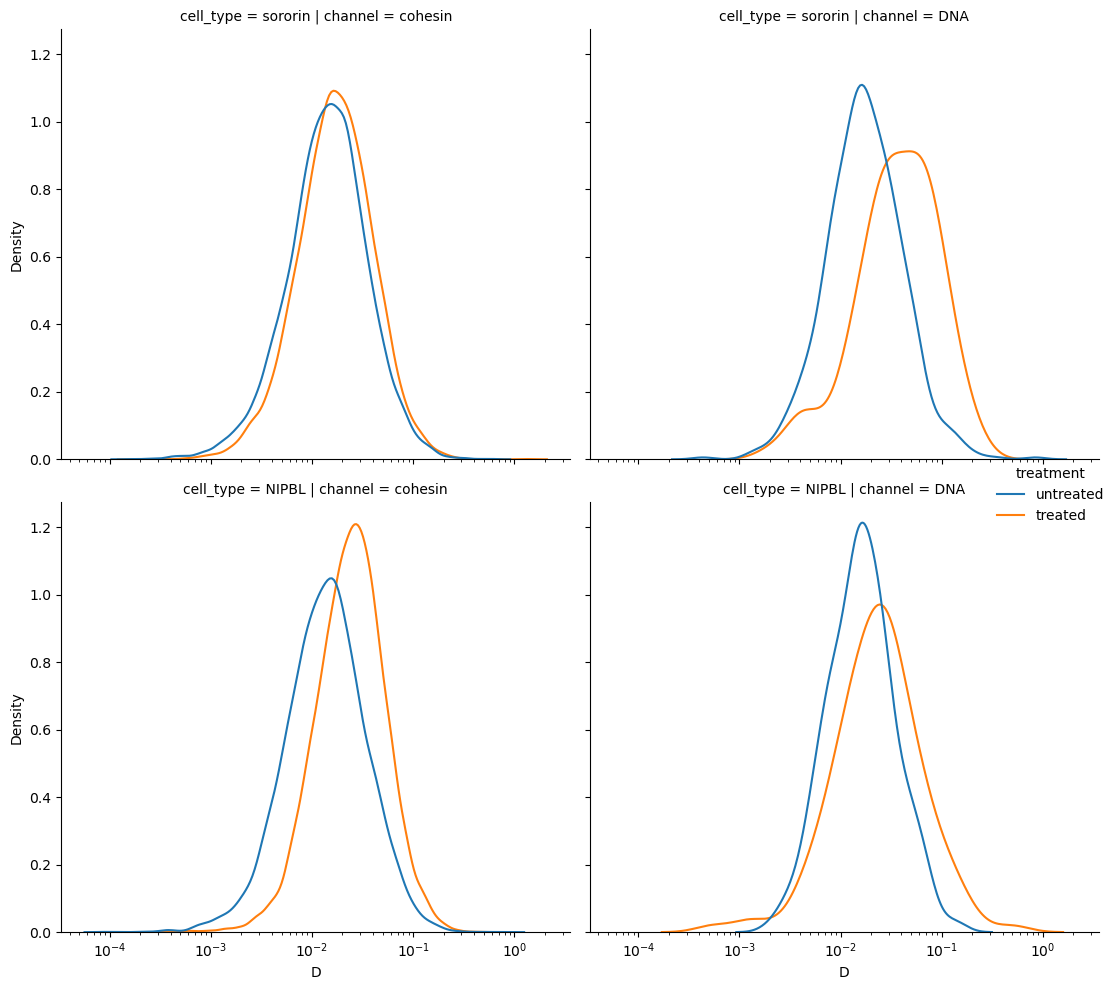

In [19]:
sns.displot(data=coefficients, x="D", log_scale=True, kind="kde", hue="treatment",common_norm=False,col='channel',row='cell_type')
plt.tight_layout()
plt.savefig('NIPBL_sororin_D.png',dpi=300)

In [69]:
print(coefficients[(coefficients.channel == 'cohesin')&(coefficients.treatment == 'untreated')&(coefficients.cell_type == 'NIPBL')].D.median())
print(coefficients[(coefficients.channel == 'DNA')&(coefficients.treatment == 'untreated')&(coefficients.cell_type == 'NIPBL')].D.median())

0.013834916562943694
0.01585773448803683


# NIPBL treated

Text(0.5, 0.98, 'NIPBL treated')

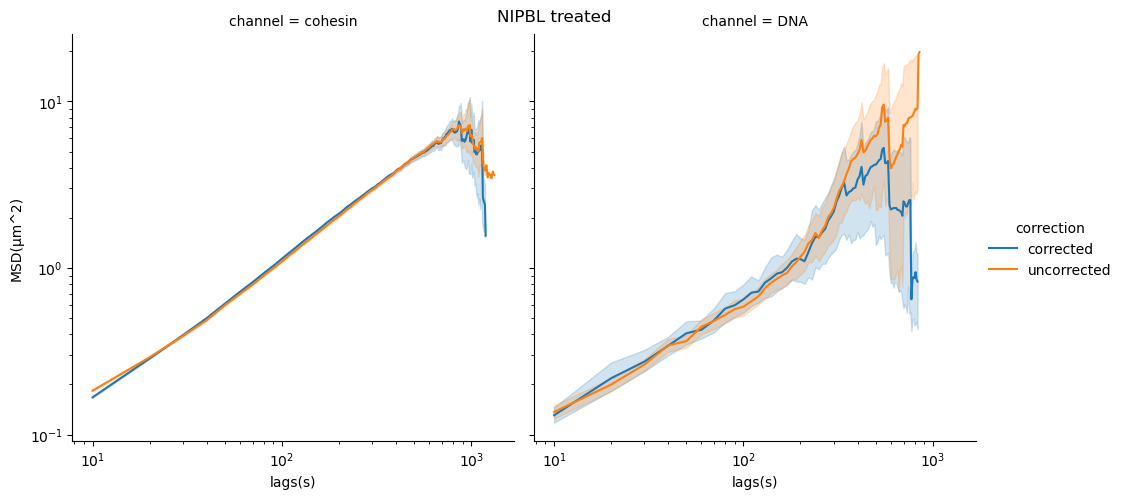

In [408]:
a = sns.relplot(data=df_NIPBL_treated, x='lags(s)', y='MSD(µm^2)', hue='correction', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
a.fig.suptitle('NIPBL treated')

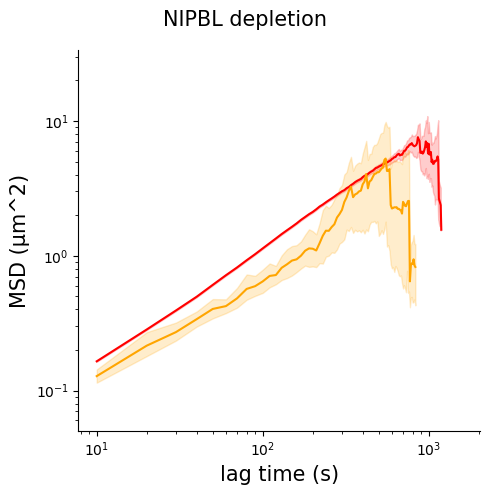

In [60]:
rel = sns.relplot(data=df_NIPBL_treated[df_NIPBL_treated.correction == 'corrected'], x='lags(s)', y='MSD(µm^2)', hue='channel', kind='line',palette=dict(cohesin='red',DNA='orange'),legend= False)
plt.xscale('log')
plt.yscale('log')
rel.fig.suptitle('NIPBL depletion',fontsize=15)
# plt.ylim(0.05,12)
plt.ylim(0.05003019815098578, 33.5852003096169)
plt.xlim(7.763671403696786, 2035.1196203997763)
plt.xlabel('lag time (s)',fontsize=15)
plt.ylabel('MSD (µm^2)',fontsize=15)
plt.tight_layout()
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/plots/MSD_cohesin_NIPBL_treated.svg',dpi=300)

# combined NIPBL

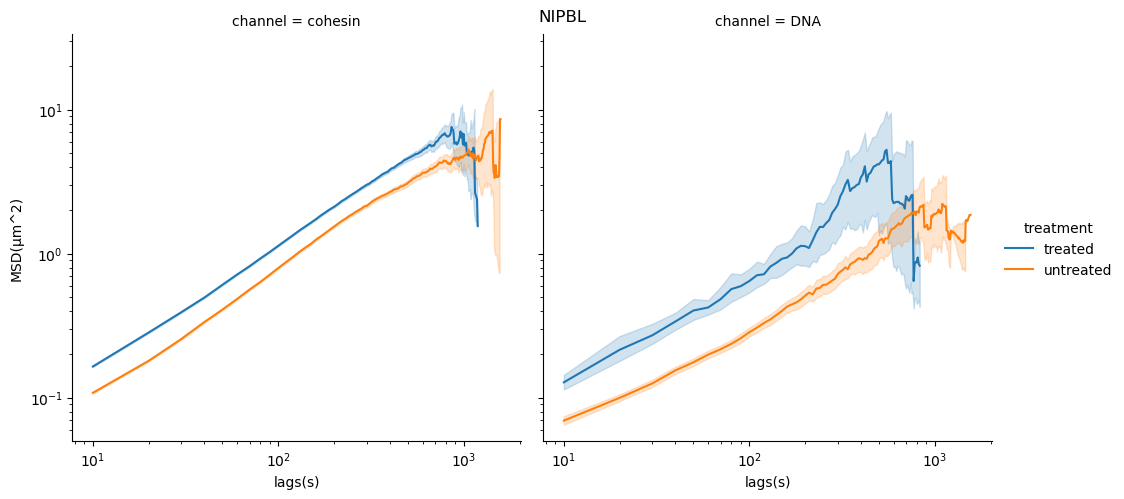

In [66]:
rel = sns.relplot(data=df_NIPBL, x='lags(s)', y='MSD(µm^2)', hue='treatment', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
rel.fig.suptitle('NIPBL')
plt.ylim(0.05003019815098578, 33.5852003096169)
plt.xlim(7.763671403696786, 2035.1196203997763)
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/plots/MSD_NIPBL.pdf',dpi=300)

In [421]:
len(df_NIPBL.file.unique())

8

## check if the correction is working

In [72]:
path_tracks_unc = ['/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
'/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv']

df_list = []

for path in path_tracks_unc:
    df = pd.read_csv(path)
    df['file'] = [path.split('/')[7]] * len(df)
    df_list.append(df)

df_tracks_unc = pd.concat(df_list)
df_tracks_unc = df_tracks_unc[df_tracks_unc.channel == 'w2']

In [87]:
df_tracks_unc = ut.filter_tracks(df_tracks_unc)
df_unc_w2_msd_rad = ut.calculate_all_pairwise_tamsd(df_tracks_unc,radial=True)

In [88]:
df_unc_w2_msd_rad.lags = df_unc_w2_msd_rad.lags*10
df_unc_w2_msd_rad.tamsd = df_unc_w2_msd_rad.tamsd*(0.16**2)

870708720.py (1): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
870708720.py (1): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
870708720.py (2): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
870708720.py (2): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
870708720.py (3): The default value of n

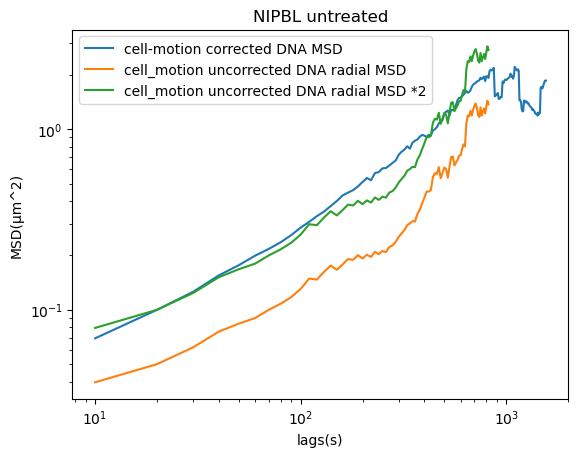

In [91]:
plt.plot(df_untreated[(df_untreated.correction == 'corrected') & (df_untreated.channel == 'DNA') & (df_untreated.cell_type == 'NIPBL')].groupby('lags(s)').mean().index,df_untreated[(df_untreated.correction == 'corrected') & (df_untreated.channel == 'DNA') & (df_untreated.cell_type == 'NIPBL')].groupby('lags(s)').mean()['MSD(µm^2)'],label= 'cell-motion corrected DNA MSD')
plt.plot(df_unc_w2_msd_rad.groupby('lags').mean().index,df_unc_w2_msd_rad.groupby('lags').mean().tamsd,label= 'cell_motion uncorrected DNA radial MSD')
plt.plot(df_unc_w2_msd_rad.groupby('lags').mean().index,df_unc_w2_msd_rad.groupby('lags').mean().tamsd*2,label= 'cell_motion uncorrected DNA radial MSD *2')
plt.title('NIPBL untreated')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('MSD(µm^2)')
plt.xlabel('lags(s)')
plt.legend()
plt.savefig('plots/correction_NIPBL_untreated.pdf',dpi=300)

# Sororin untreated

Text(0.5, 0.98, 'Sororin untreated')

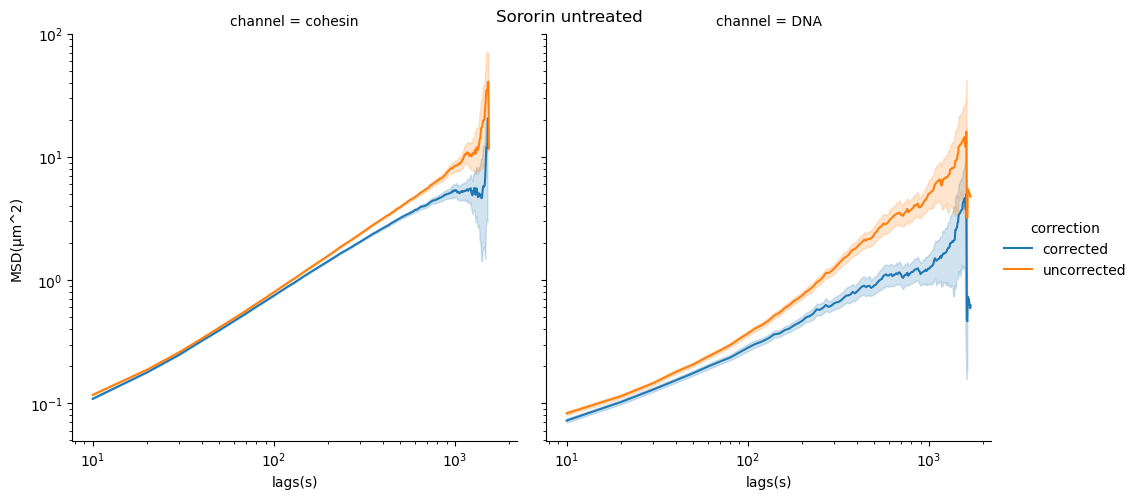

In [409]:
a = sns.relplot(data=df_sororin_untreated, x='lags(s)', y='MSD(µm^2)', hue='correction', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
a.fig.suptitle('Sororin untreated')

## Check if the correction is working

In [43]:
path_tracks_unc = ['/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230529_Rad21-Halo_Sororin_2D5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230529_Rad21-Halo_Sororin_2D5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
'/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230529_Rad21-Halo_Sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230529_Rad21-Halo_Sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
'/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230531_Rad21-Halo_sororin_2D5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230531_Rad21-Halo_sororin_2D5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv',
'/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_merged__20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv']

df_list = []

for path in path_tracks_unc:
    df = pd.read_csv(path)
    df['file'] = [path.split('/')[7]] * len(df)
    df_list.append(df)

df_tracks_unc = pd.concat(df_list)
df_tracks_unc = df_tracks_unc[df_tracks_unc.channel == 'w2'] 


In [44]:
df_tracks_unc = ut.filter_tracks(df_tracks_unc)
df_unc_w2_msd_rad = ut.calculate_all_pairwise_tamsd(df_tracks_unc,radial=True)

3225530663.py (1): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
3225530663.py (1): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
3225530663.py (2): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
3225530663.py (2): The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
3225530663.py (3): The default value

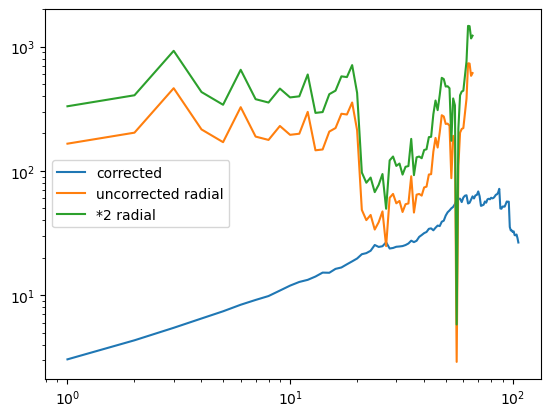

In [42]:
plt.plot(df[(df.correction == 'corrected') & (df.channel == 'w2')].groupby('lags').mean().index,df[(df.correction == 'corrected') & (df.channel == 'w2')].groupby('lags').mean().tamsd,label= 'corrected')
plt.plot(df_unc_w2_msd_rad.groupby('lags').mean().index,df_unc_w2_msd_rad.groupby('lags').mean().tamsd,label= 'uncorrected radial')
plt.plot(df_unc_w2_msd_rad.groupby('lags').mean().index,df_unc_w2_msd_rad.groupby('lags').mean().tamsd*2,label= '*2 radial')

plt.xscale('log')
plt.yscale('log')
plt.legend()

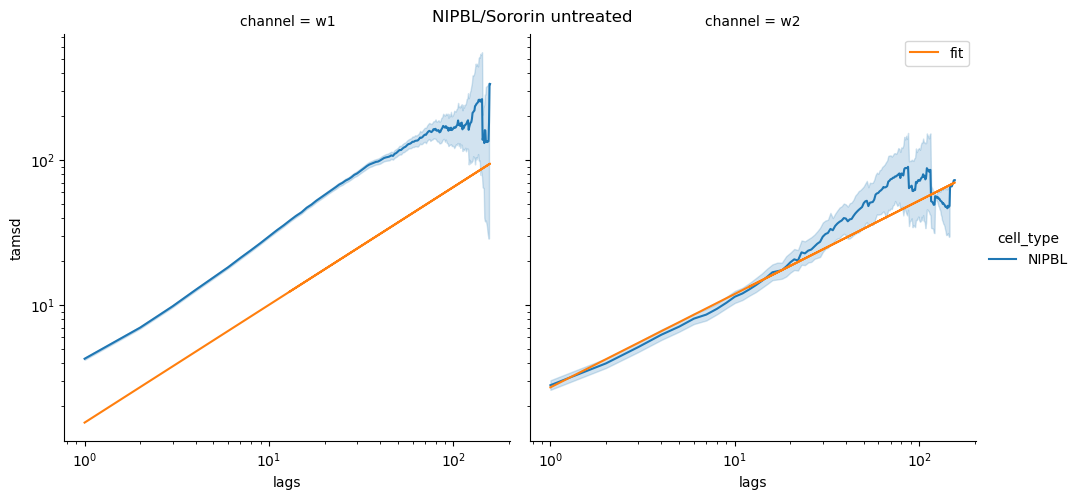

In [238]:
rel = sns.relplot(data=df_noaux, x='lags', y='tamsd', hue='cell_type', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
rel.fig.suptitle('NIPBL/Sororin untreated')

a = rel.axes.flatten()

for y,x,ax in zip([y_w1,y_w2],[x_w1,x_w2],a):
    ax.plot(x,y,label='fit')
    ax.set_xscale('log')
    ax.set_yscale('log')

a[1].legend()

# Sororin treated

Text(0.5, 0.98, 'Sororin treated')

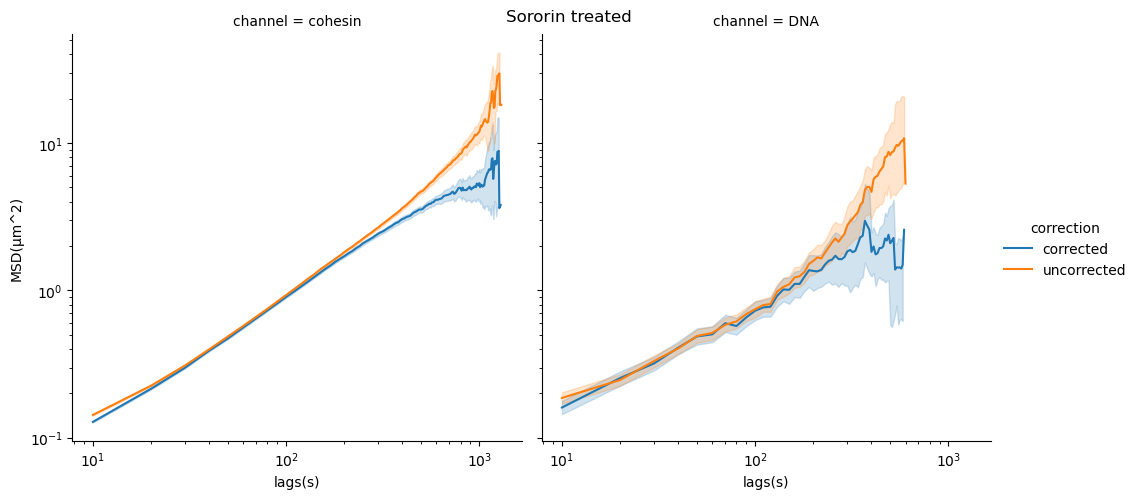

In [410]:
a = sns.relplot(data=df_sororin_treated, x='lags(s)', y='MSD(µm^2)', hue='correction', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
a.fig.suptitle('Sororin treated')

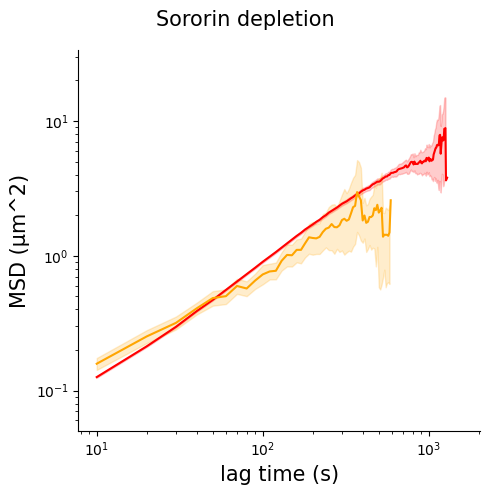

In [61]:
rel = sns.relplot(data=df_sororin_treated[df_sororin_treated.correction == 'corrected'], x='lags(s)', y='MSD(µm^2)', hue='channel', kind='line',palette=dict(cohesin='red',DNA='orange'),legend=False)
plt.xscale('log')
plt.yscale('log')
rel.fig.suptitle('Sororin depletion',fontsize=15)
plt.ylim(0.05003019815098578, 33.5852003096169)
plt.xlim(7.763671403696786, 2035.1196203997763)
# plt.legend(fontsize=12)
plt.xlabel('lag time (s)',fontsize=15)
plt.ylabel('MSD (µm^2)',fontsize=15)
plt.tight_layout()
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/plots/MSD_cohesin_sororin_treated.svg',dpi=300)

# Combined sororin

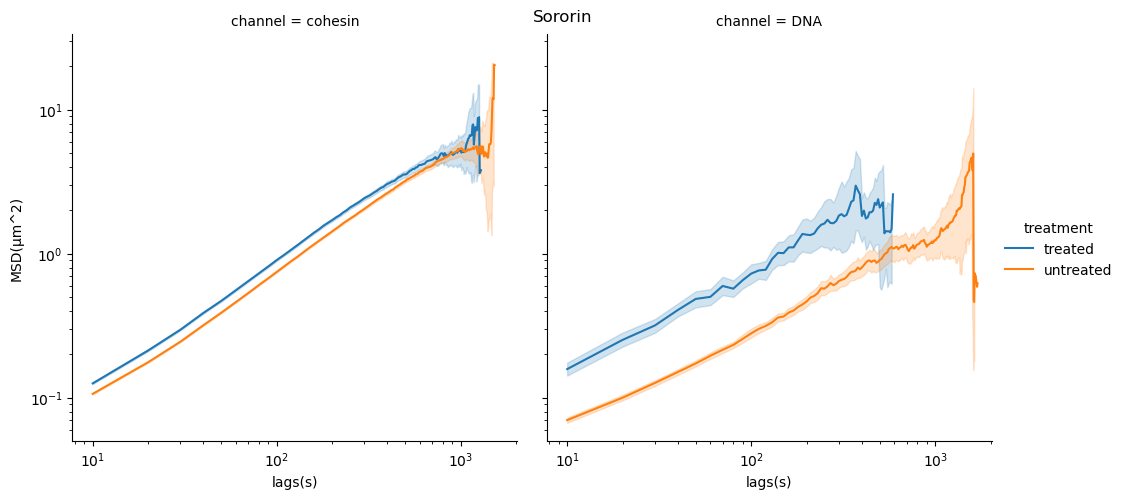

In [67]:
rel = sns.relplot(data=df_sororin, x='lags(s)', y='MSD(µm^2)', hue='treatment', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
rel.fig.suptitle('Sororin')
plt.ylim(0.05003019815098578, 33.5852003096169)
plt.xlim(7.763671403696786, 2035.1196203997763)
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/plots/MSD_sororin.pdf',dpi=300)

In [424]:
df_sororin.file.unique()

array(['20230602_Rad21-Halo_sororin_2D5_3h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230602_Rad21-Halo_sororin_2D5_3h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230602_Rad21-Halo_sororin_2D5_3h_3_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20220907_Rad21-Halo_SPT_2D5_Sororin_noaux_40mW_2',
       '20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230529_Rad21-Halo_Sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230529_Rad21-Halo_Sororin_2D5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230531_Rad21-Halo_sororin_2D5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB'],
      dtype=object)

# All untreated together

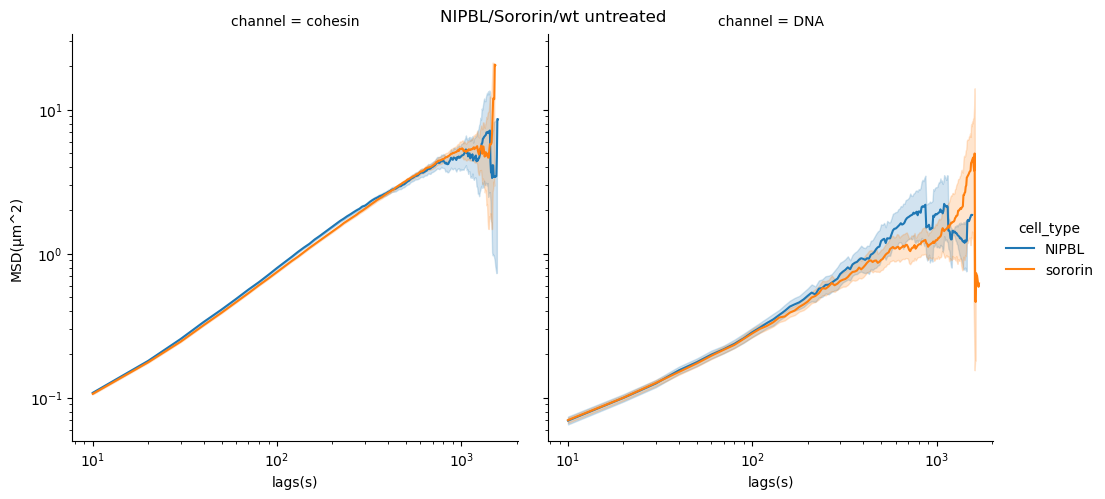

In [32]:
rel = sns.relplot(data=df_untreated, x='lags(s)', y='MSD(µm^2)', hue='cell_type', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
rel.fig.suptitle('NIPBL/Sororin/wt untreated')
plt.ylim(0.05003019815098578, 33.5852003096169)
plt.xlim(7.763671403696786, 2035.1196203997763)
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/plots/untreated_nipbl_sororin.svg',dpi=300)

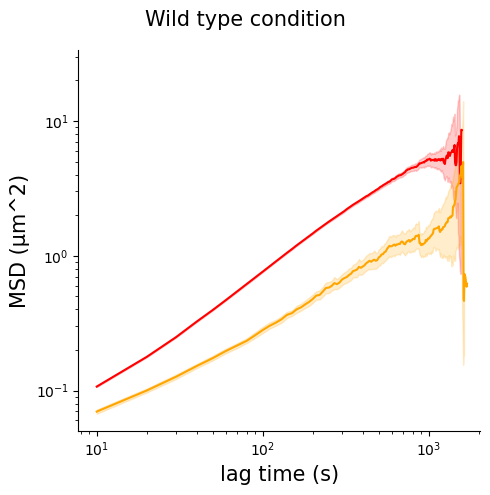

In [59]:
rel = sns.relplot(data=df_untreated, x='lags(s)', y='MSD(µm^2)', hue='channel', kind='line',palette=dict(cohesin='red',DNA='orange'),legend=False)
plt.xscale('log')
plt.yscale('log')
rel.fig.suptitle('Wild type condition',fontsize=15)
# plt.ylim(0.05,12)
plt.ylim(0.05003019815098578, 33.5852003096169)
plt.xlim(7.763671403696786, 2035.1196203997763)
# plt.setp(rel._legend().get_texts(), fontsize='12')
plt.xlabel('lag time (s)',fontsize=15)
plt.ylabel('MSD (µm^2)',fontsize=15)
plt.tight_layout()
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/plots/MSD_cohesin_NIPBL_sororin_untreated.svg',dpi=300)

In [414]:
df_untreated.file.unique()

array(['20230529_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230526_Rad21-Halo_NIPBL_1C5_0h_3_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230526_Rad21-Halo_NIPBL_1C5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230526_Rad21-Halo_NIPBL_1C5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20220907_Rad21-Halo_SPT_2D5_Sororin_noaux_40mW_2',
       '20230531_Rad21-Halo_sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230529_Rad21-Halo_Sororin_2D5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230529_Rad21-Halo_Sororin_2D5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230531_Rad21-Halo_sororin_2D5_0h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB'],
      dtype=object)

# all treated together

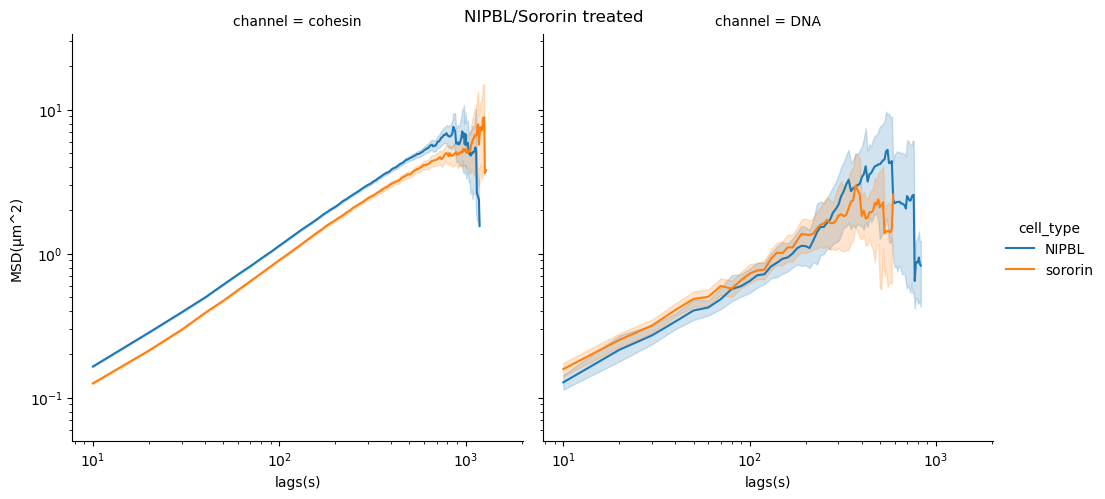

In [71]:
rel = sns.relplot(data=df_treated, x='lags(s)', y='MSD(µm^2)', hue='cell_type', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
rel.fig.suptitle('NIPBL/Sororin treated')
plt.ylim(0.05003019815098578, 33.5852003096169)
plt.xlim(7.763671403696786, 2035.1196203997763)
plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/plots/MSD_auxin.pdf',dpi=300)

In [426]:
df_treated.file.unique()

array(['20230529_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230526_Rad21-Halo_NIPBL_1C5_6h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230531_Rad21-Halo_NIPBL_1C5_6h_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230529_Rad21-Halo_NIPBL_1C5_6h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230602_Rad21-Halo_sororin_2D5_3h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230602_Rad21-Halo_sororin_2D5_3h_1_FullseqTIRF-Cy5-mCherryGFPWithSMB',
       '20230602_Rad21-Halo_sororin_2D5_3h_3_FullseqTIRF-Cy5-mCherryGFPWithSMB'],
      dtype=object)

# WT

Text(0.5, 0.98, 'Rad21 WT')

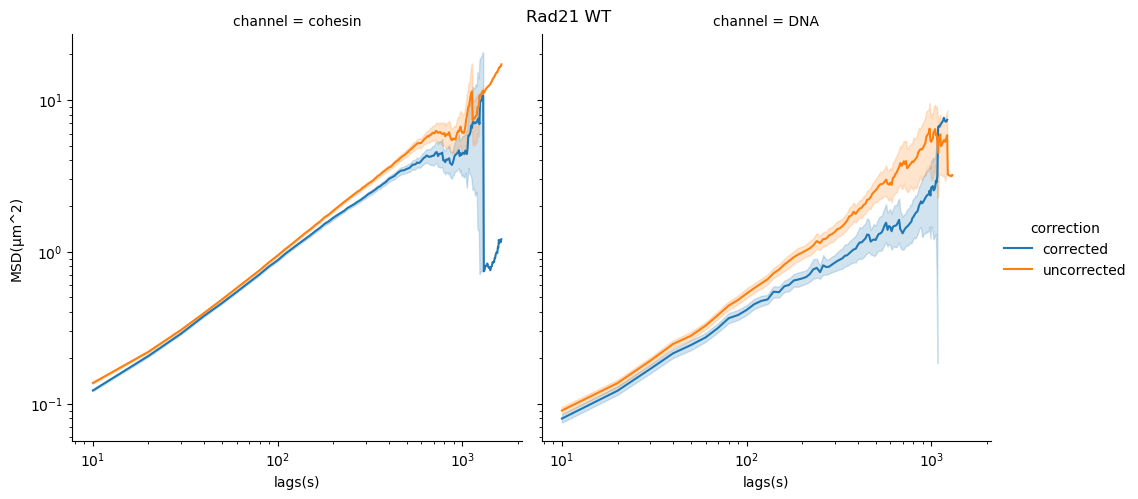

In [10]:
a = sns.relplot(data=df_wt, x='lags(s)', y='MSD(µm^2)', hue='correction', kind='line', col='channel')
plt.xscale('log')
plt.yscale('log')
a.fig.suptitle('Rad21 WT')

# plot track for one cell of DNA and cohesin

In [15]:
df_track = pd.read_csv('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/tracks_corrected__20230526_Rad21-Halo_NIPBL_1C5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB.csv')

In [16]:
labels = np.load('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/results/20230526_Rad21-Halo_NIPBL_1C5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB/new_labels__20230526_Rad21-Halo_NIPBL_1C5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB__w2.npy')

In [17]:
df_track[df_track.channel == 'w2'].groupby('track_id').count().sort_values('x',ascending=False).head(10)

,Unnamed: 0.1,Unnamed: 0,x,y,frame,label,channel,z,xres,yres,zres,degree_av_rotation,degree_av_translation
track_id,,,,,,,,,,,,,
25847,85,85,85,85,85,85,85,85,85,85,85,85,85
26137,80,80,80,80,80,80,80,80,80,80,80,80,80
26076,58,58,58,58,58,58,58,58,58,58,58,58,58
24783,52,52,52,52,52,52,52,52,52,52,52,52,52
26131,51,51,51,51,51,51,51,51,51,51,51,51,51
24933,48,48,48,48,48,48,48,48,48,48,48,48,48
24780,35,35,35,35,35,35,35,35,35,35,35,35,35
24855,35,35,35,35,35,35,35,35,35,35,35,35,35
25092,34,34,34,34,34,34,34,34,34,34,34,34,34


In [18]:
df_track[df_track.track_id == 25847]

,Unnamed: 0.1,Unnamed: 0,x,y,frame,track_id,label,channel,z,xres,yres,zres,degree_av_rotation,degree_av_translation
103266,189988,2490,279.984304,302.405131,60,25847,18,w2,0.0,-30.629368,22.402680,0.0,0.010953,4.30932
103319,190007,2513,280.013157,302.788800,61,25847,18,w2,0.0,-30.866113,22.888887,0.0,0.010953,4.30932
103369,190034,2555,279.351877,303.375070,62,25847,18,w2,0.0,-31.610029,23.426229,0.0,0.010953,4.30932
103423,190058,2589,279.515058,302.428128,63,25847,18,w2,0.0,-31.391966,23.077372,0.0,0.010953,4.30932
103485,190092,2631,279.155229,303.010694,64,25847,18,w2,0.0,-32.025491,23.824816,0.0,0.010953,4.30932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107504,192408,6107,270.112563,307.707122,173,25847,18,w2,0.0,-44.855097,37.139996,0.0,0.010953,4.30932
107558,192458,6190,271.427023,307.003300,176,25847,18,w2,0.0,-43.392325,36.345066,0.0,0.010953,4.30932
107601,192501,6265,271.560586,307.833582,178,25847,18,w2,0.0,-43.242416,37.282967,0.0,0.010953,4.30932
107627,192514,6299,271.357774,307.714629,179,25847,18,w2,0.0,-43.223843,37.254193,0.0,0.010953,4.30932


In [19]:
df_track[(df_track.label == 18)&(df_track.channel == 'w2')].groupby('track_id').count().sort_values('x',ascending=False).head(10)

,Unnamed: 0.1,Unnamed: 0,x,y,frame,label,channel,z,xres,yres,zres,degree_av_rotation,degree_av_translation
track_id,,,,,,,,,,,,,
25847,85,85,85,85,85,85,85,85,85,85,85,85,85
24783,52,52,52,52,52,52,52,52,52,52,52,52,52
24933,48,48,48,48,48,48,48,48,48,48,48,48,48
24993,20,20,20,20,20,20,20,20,20,20,20,20,20
25065,19,19,19,19,19,19,19,19,19,19,19,19,19
24922,16,16,16,16,16,16,16,16,16,16,16,16,16
25614,15,15,15,15,15,15,15,15,15,15,15,15,15
24834,14,14,14,14,14,14,14,14,14,14,14,14,14
27400,10,10,10,10,10,10,10,10,10,10,10,10,10


In [20]:
track_w1 = df_track[df_track.track_id.isin([3613,1669,5031])]
track_w2 = df_track[df_track.track_id.isin([25847,24783,24933])]

In [104]:
track_w1.to_csv('track_w1.csv')

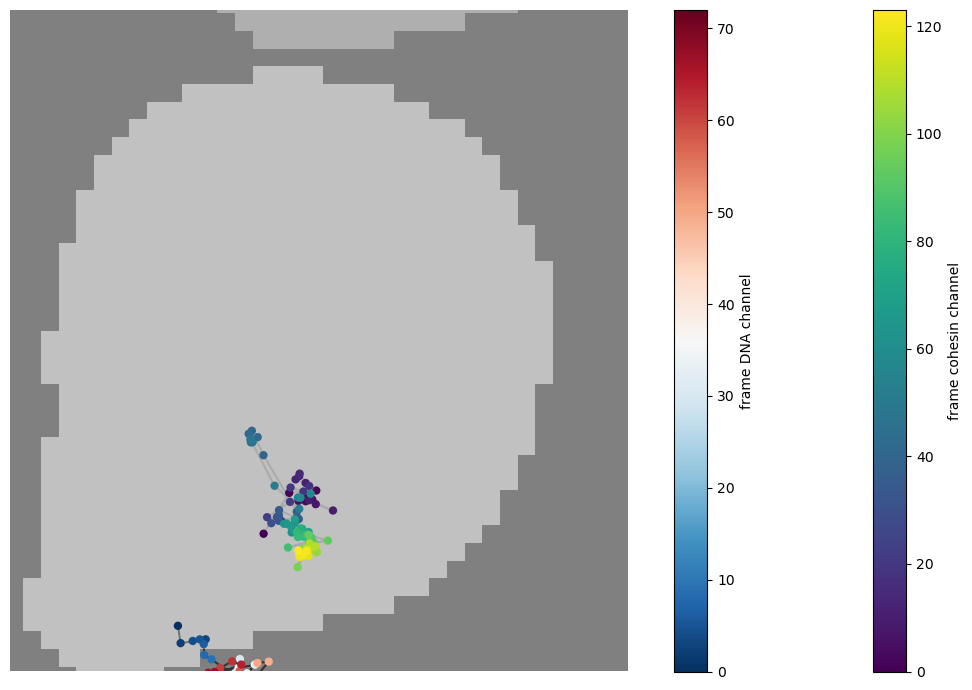

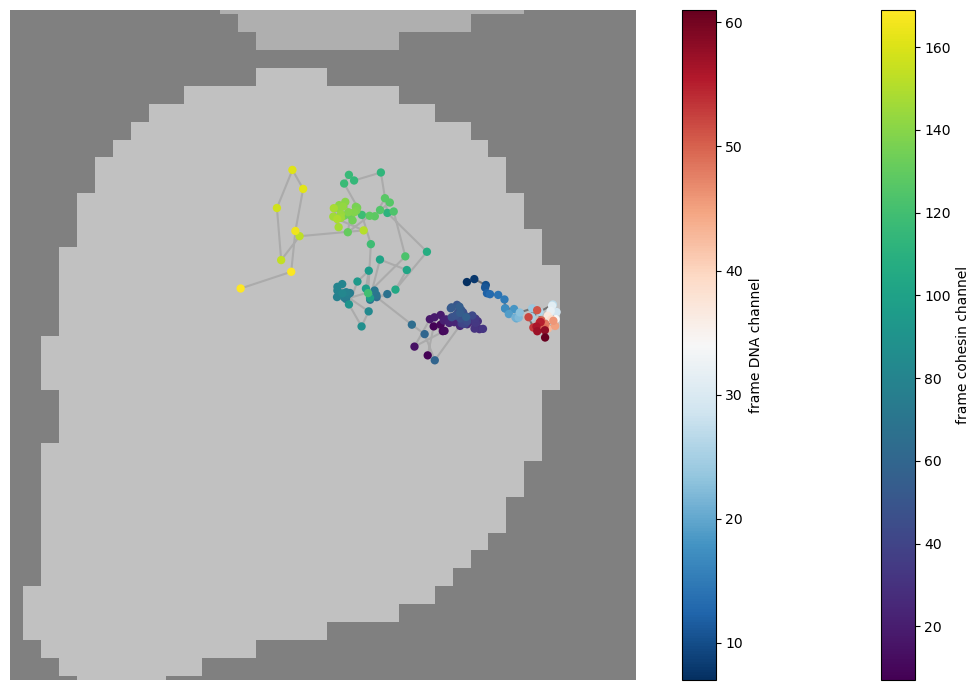

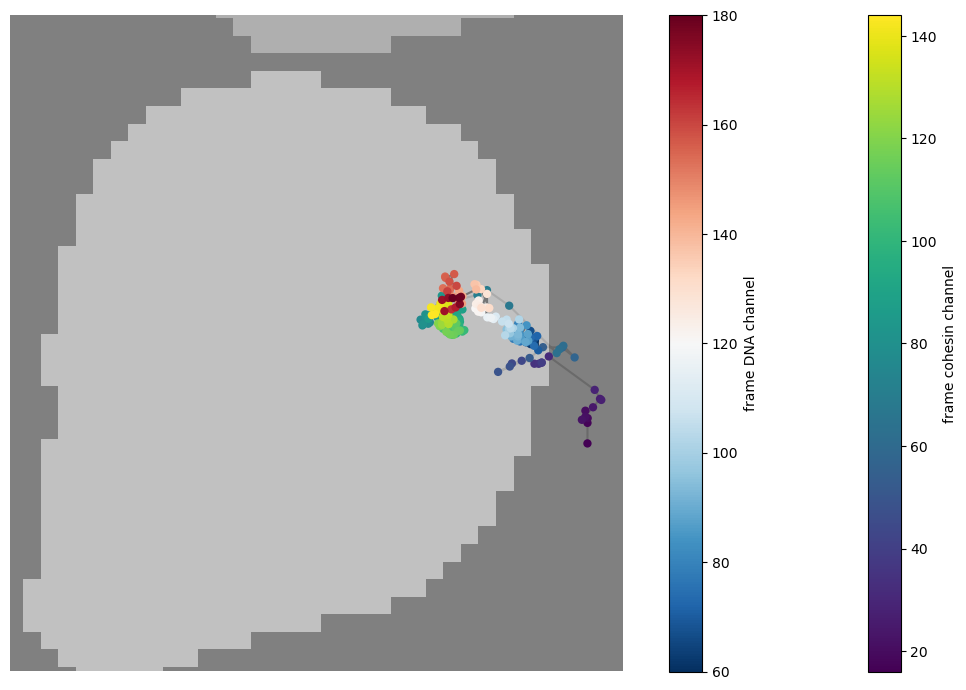

In [29]:

for i,j in zip(track_w1.track_id.unique(),track_w2.track_id.unique()):
    fig,ax =plt.subplots(figsize=(12,7))

    t1 = track_w1[track_w1.track_id == i]
    t2 = track_w2[track_w2.track_id == j]

    a = ax.scatter(data=t1,x='x',y='y',c=t1.frame,cmap='viridis',linewidth=0,zorder=1)
    b = ax.scatter(data=t2,x='x',y='y',c=t2.frame,cmap='RdBu_r',linewidth=0,zorder=1)

    ax.plot(t1.x,t1.y,c="lightgray",zorder=0)
    ax.plot(t2.x,t2.y,c="dimgray",zorder=0)
    fig.colorbar(a,label='frame cohesin channel')
    fig.colorbar(b,label='frame DNA channel')

    ax.imshow(labels[0],cmap='gray',alpha=0.5,zorder=0,interpolation='nearest')
    plt.xlim(220,290)
    plt.ylim(265,340)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'plots/tracks_NIPBL_no_aux_track_id_{i}.svg',dpi=300,transparent=True)
    plt.show()

# plt.savefig('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/plots/file_20230526_Rad21-Halo_NIPBL_1C5_0h_2_track_3613_25847.png',dpi=300)

In [19]:
from tifffile import imread

In [20]:
im_w1 = imread('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/images/20230526_Rad21-Halo_NIPBL_1C5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB_w1.tif')
im_w2 = imread('/tungstenfs/scratch/ggiorget/nessim/cohesin_live_cell_analysis/images/20230526_Rad21-Halo_NIPBL_1C5_0h_2_FullseqTIRF-Cy5-mCherryGFPWithSMB_w2.tif')

In [92]:
track_w1 = df_track[df_track.track_id.isin([3613])]#,1669,5031])]
track_w2 = df_track[df_track.track_id.isin([25847])]#,24783,24933])]

In [102]:
np.shape(im_w1[6:20,...])[0]

14

In [101]:
for i in range(np.shape(im_w1[6:20,...])[0]):
    print(i)

TypeError: 'int' object is not iterable

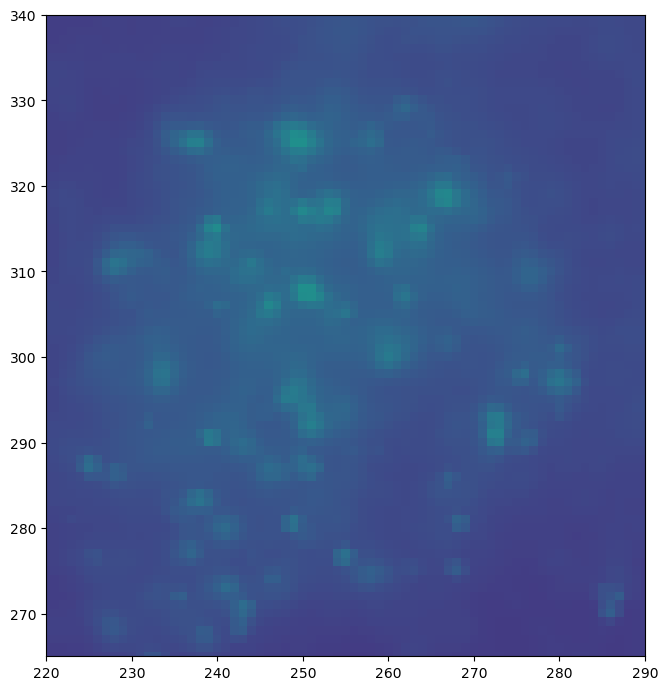

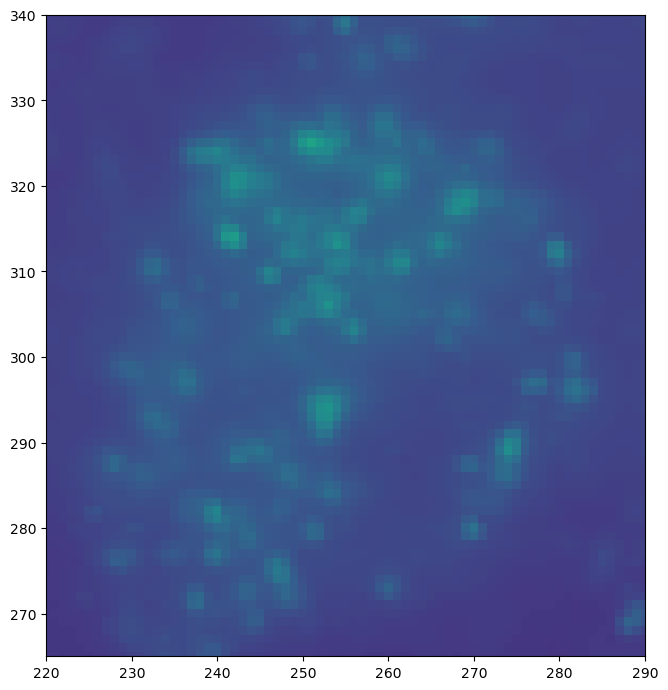

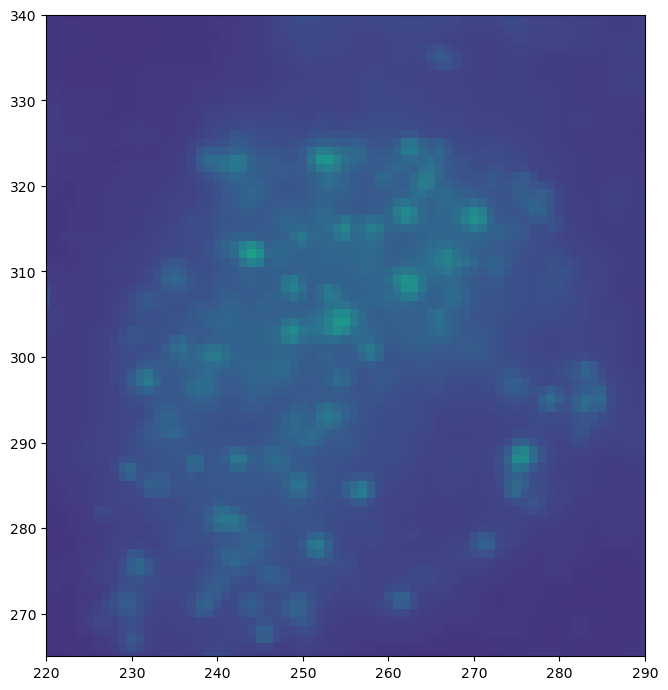

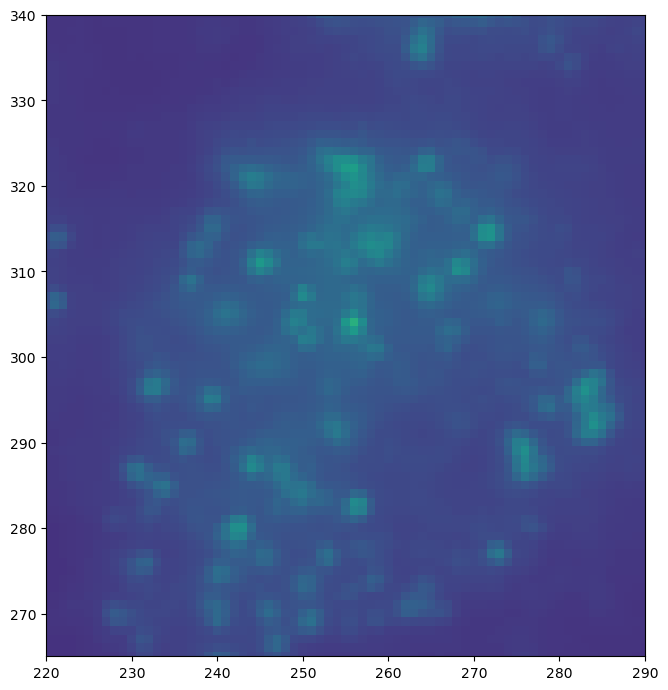

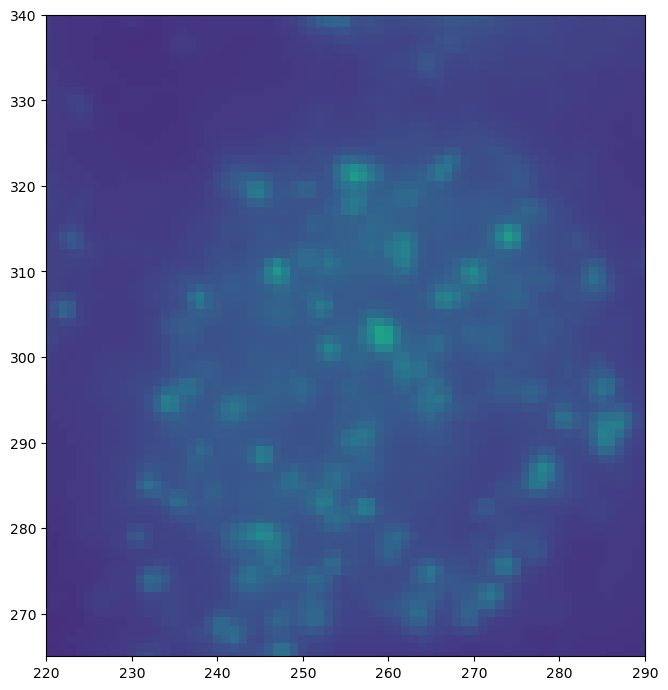

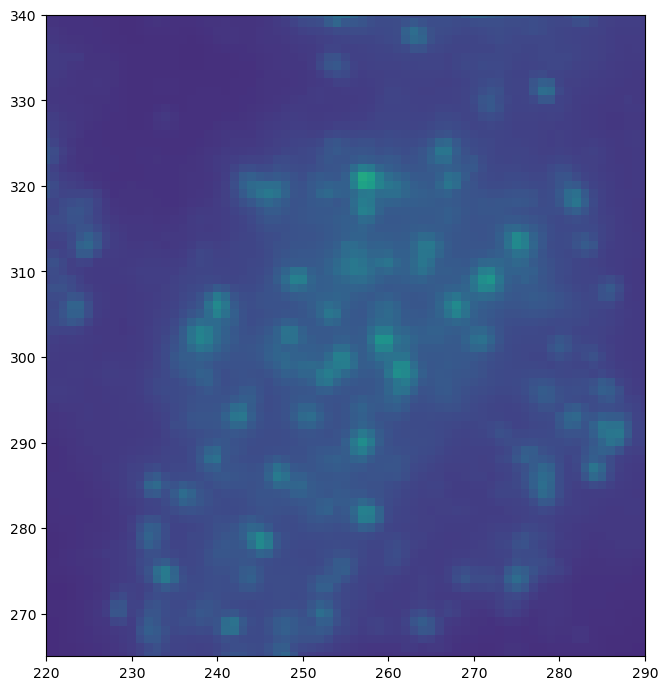

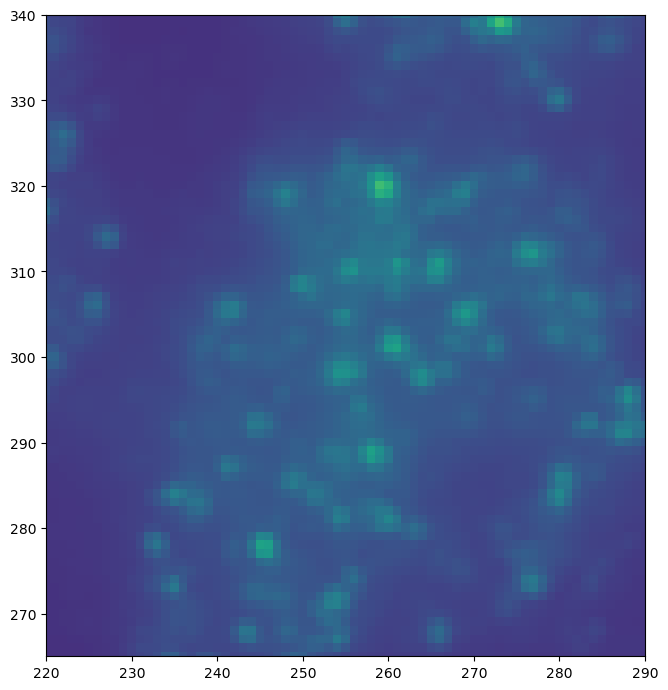

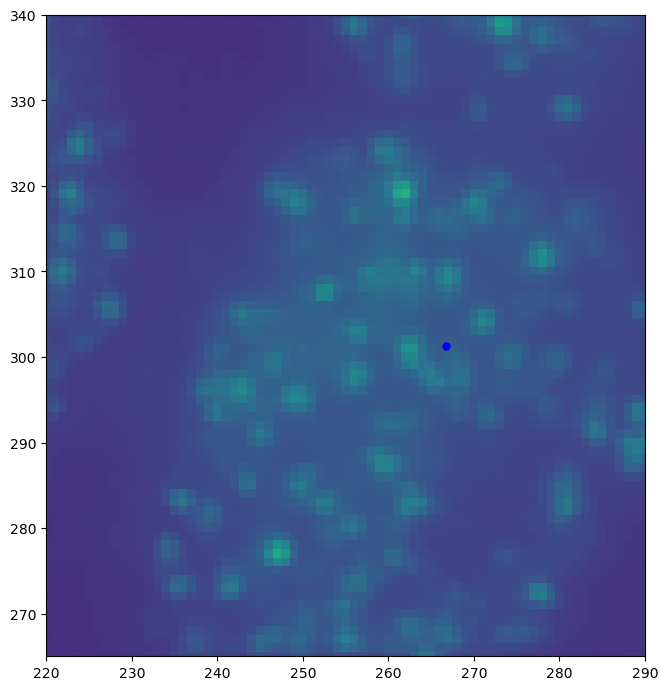

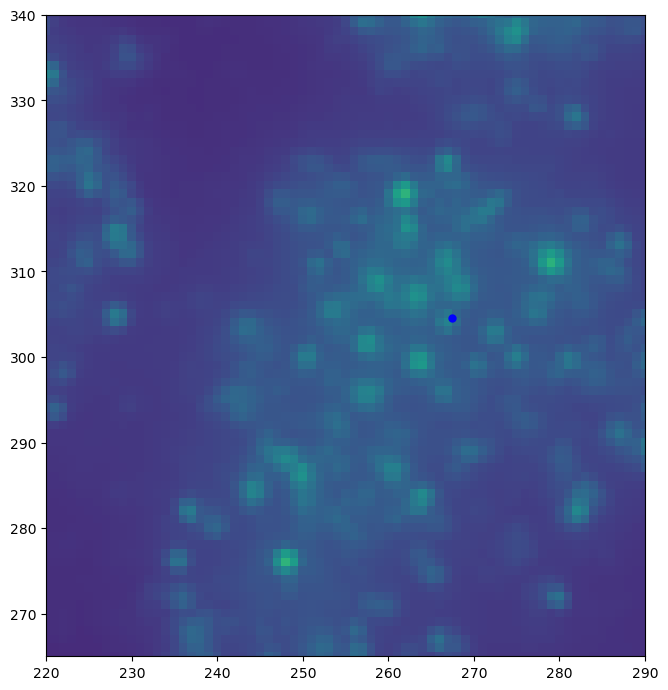

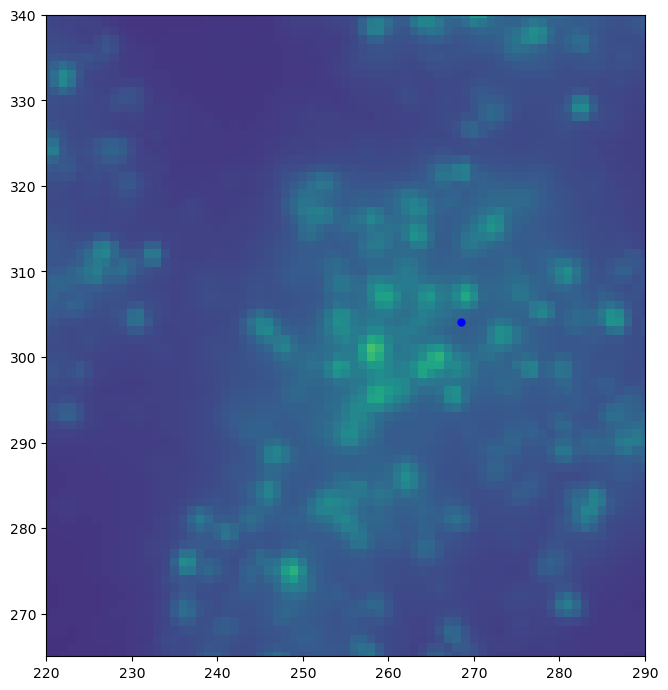

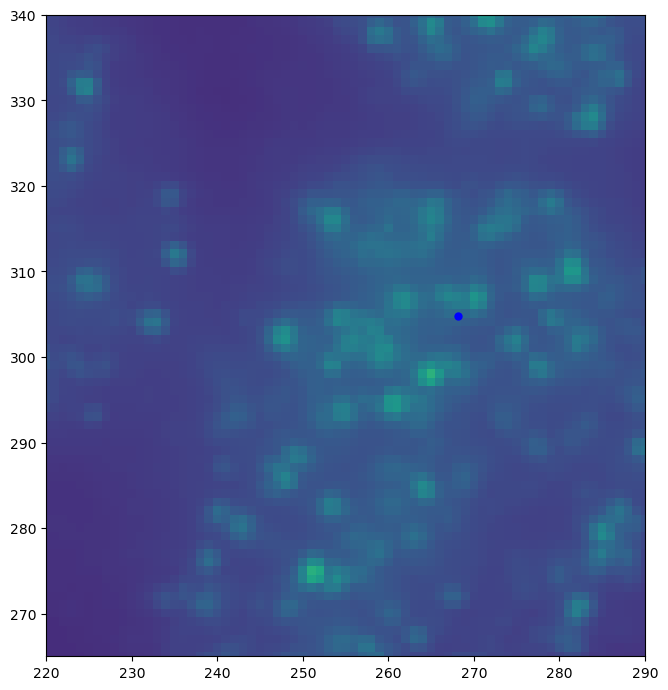

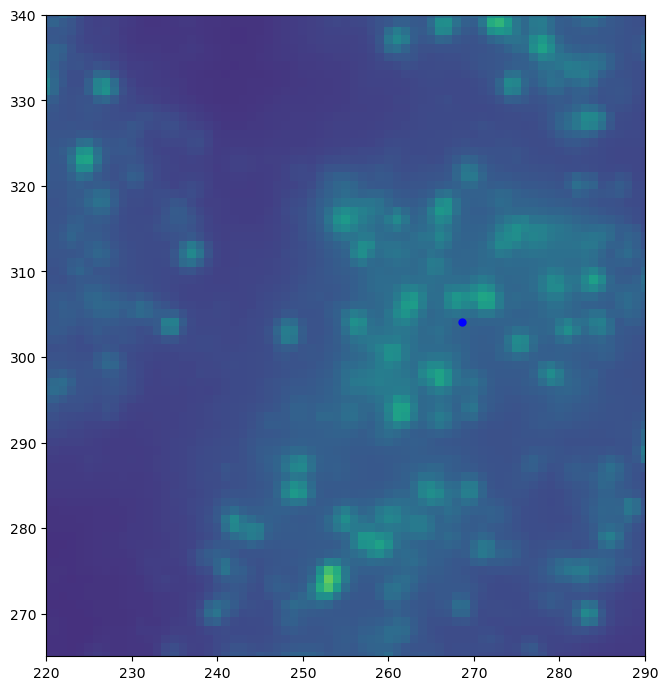

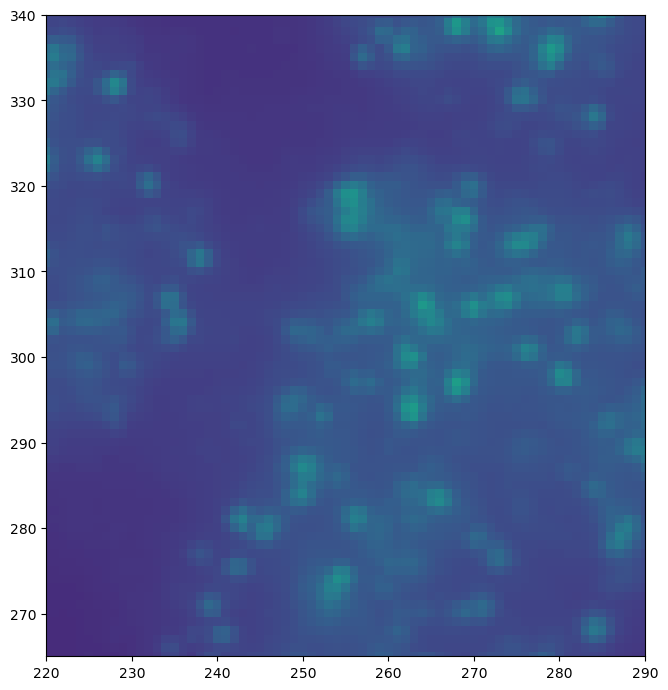

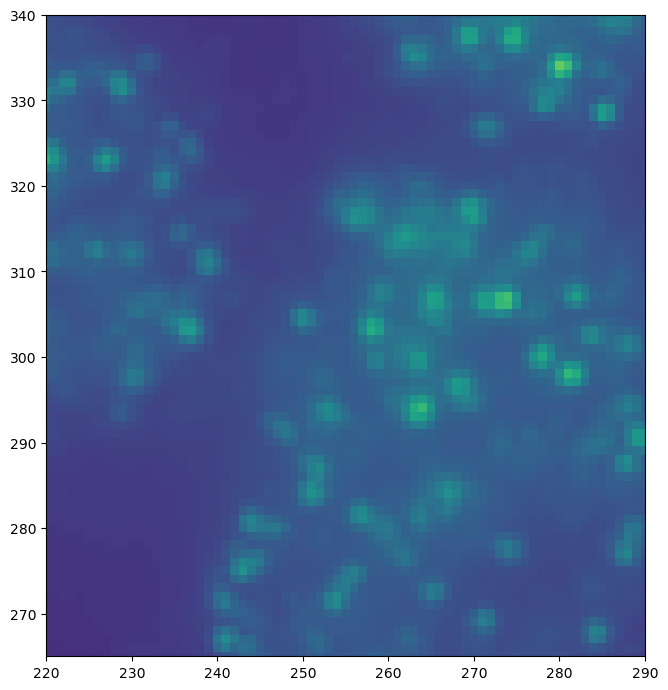

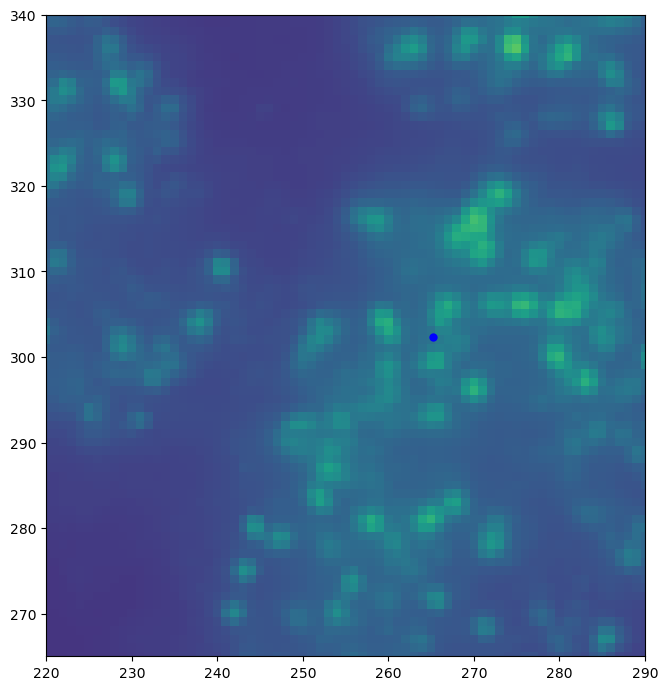

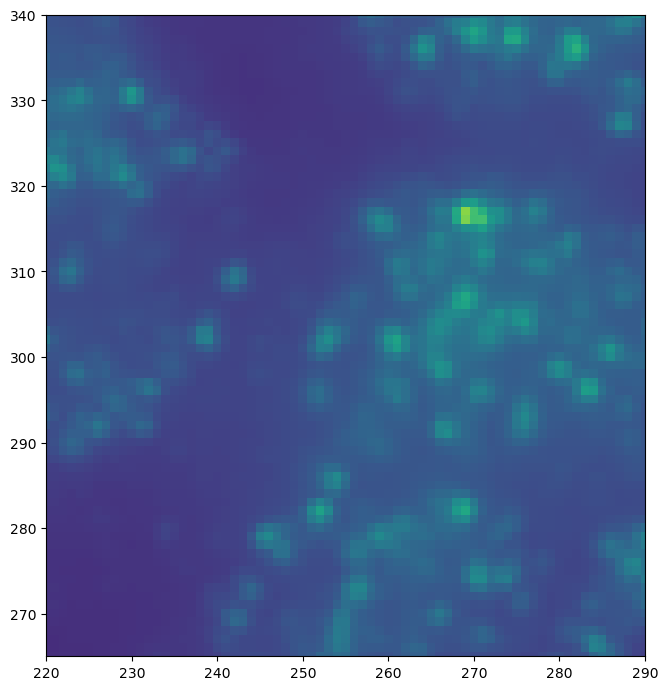

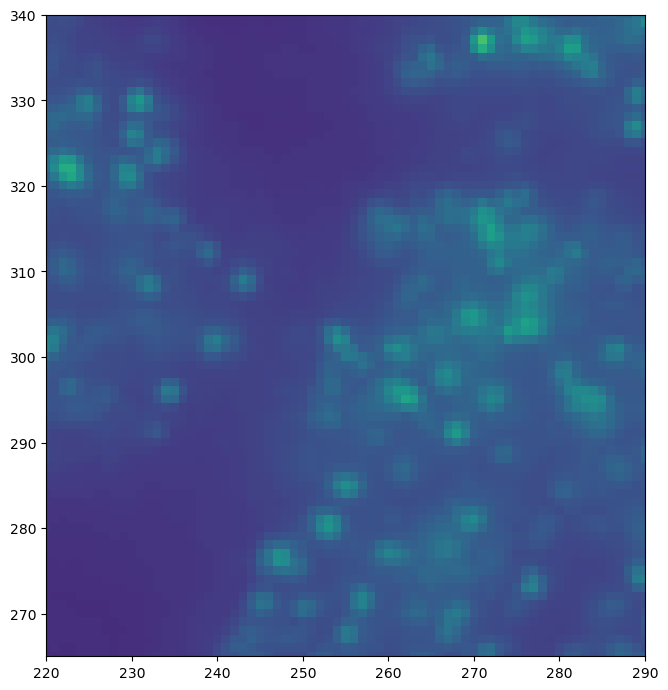

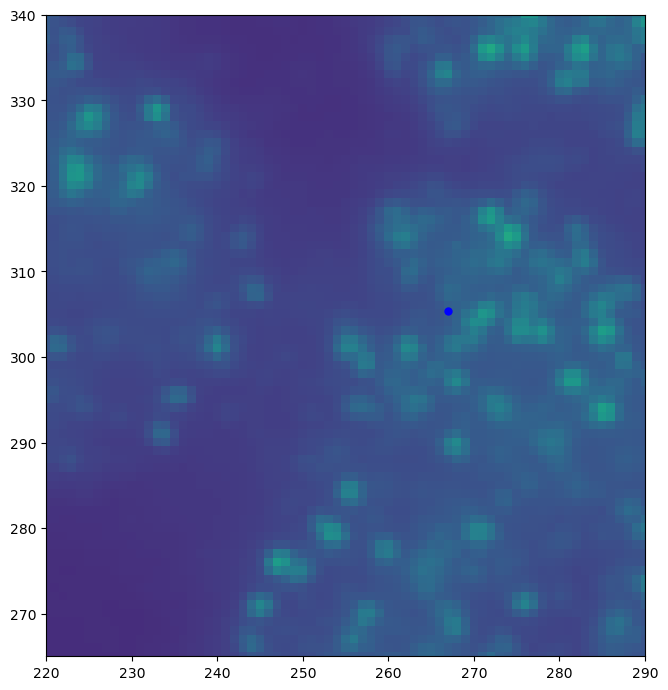

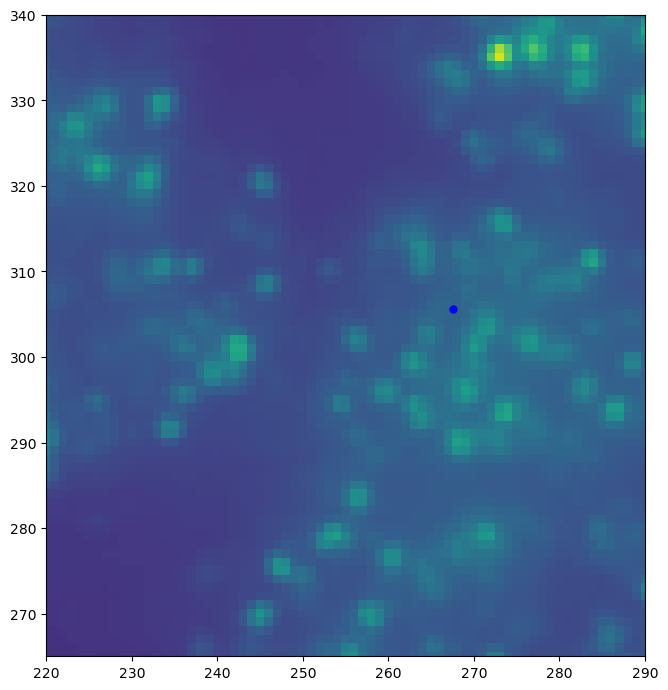

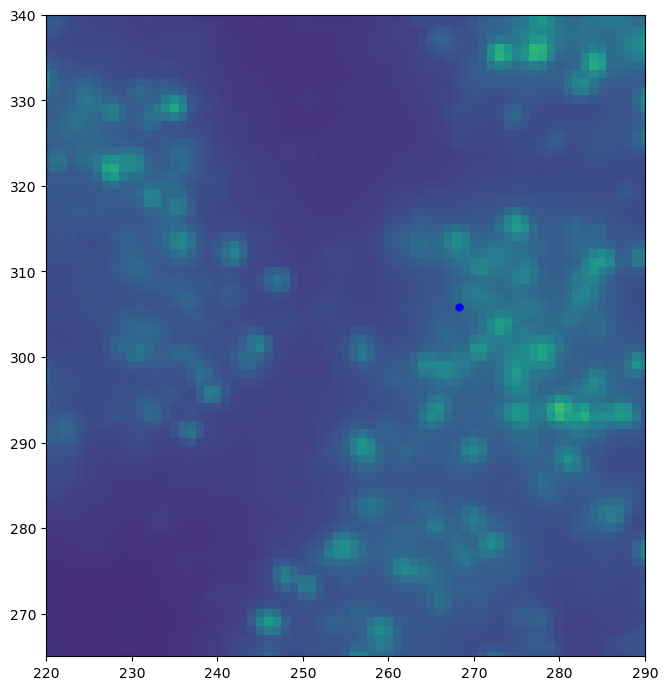

In [103]:

t1 = track_w1
t2 = track_w2

for i in range(np.shape(im_w1[:20,...])[0]):
    fig,ax =plt.subplots(figsize=(12,7))

    a = ax.scatter(data=t1[t1.frame == i],x='x',y='y',c='blue',linewidth=0,zorder=1)
    b = ax.scatter(data=t2[t2.frame == j],x='x',y='y',c='red',linewidth=0,zorder=1)

    # ax.plot(t1.x,t1.y,c="lightgray",zorder=0)
    # ax.plot(t2.x,t2.y,c="dimgray",zorder=0)
    # fig.colorbar(a,label='frame cohesin')
    # fig.colorbar(b,label='frame DNA')

    ax.imshow(np.max(im_w1[i],axis=0))
    plt.tight_layout()
    plt.xlim(220,290)
    plt.ylim(265,340)
    plt.show()
